![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

# Train Legal NER

In [0]:
from johnsnowlabs import nlp, legal

#🔎 CoNLL Data Prep

In [0]:
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/legal-nlp/data/conll_noO.conll -O conll_legal.conll
dbutils.fs.cp("file:/databricks/driver/conll_legal.conll", "dbfs:/") 

Out[6]: True

In [0]:
with open("conll_legal.conll") as f:
    train_txt =f.read()

print(train_txt[:500])

Exhibit NN NN O
10.6 NN NN O
memorandum NN NN B-DOC
Between NN NN O
(hereinafter NN NN B-PARTY
collectively NN NN I-PARTY
called NN NN I-PARTY
"Parties" NN NN I-PARTY
and NN NN I-PARTY
individually NN NN I-PARTY
called NN NN I-PARTY
"Party"), NN NN I-PARTY
And NN NN O
MBE NN NN B-PARTY

ARTICLE NN NN O
II NN NN O
ENGAGEMENT NN NN O
OF NN NN O
ZEBRA NN NN B-PARTY
BRAZIL NN NN I-PARTY
6 NN NN O

ARTICLE NN NN O
II NN NN O
ENGAGEMENT NN NN O
OF NN NN O
ZEBRA NN NN B-PARTY
BRAZIL NN NN I-PARTY
6 NN

In [0]:
from sparknlp.training import CoNLL

training_data = CoNLL().readDataset(spark, 'file:/dbfs/conll_legal.conll')

training_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 text| document| sentence| token| pos| label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
Exhibit 10.6 memo...|[{document, 0, 11...|[{document, 0, 11...|[{token, 0, 6, Ex...|[{pos, 0, 6, NN, ...|[{named_entity, 0...|
ARTICLE II ENGAGE...|[{document, 0, 38...|[{document, 0, 38...|[{token, 0, 6, AR...|[{pos, 0, 6, NN, ...|[{named_entity, 0...|
ARTICLE II ENGAGE...|[{document, 0, 38...|[{document, 0, 38...|[{token, 0, 6, AR...|[{pos, 0, 6, NN, ...|[{named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows

In [0]:
training_data.printSchema()

root
-- text: string (nullable = true)
-- document: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- sentence: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- token: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- pos: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- label: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)

In [0]:
%time training_data.count()

CPU times: user 239 µs, sys: 101 µs, total: 340 µs
Wall time: 817 ms
Out[11]: 5022

In [0]:
import pyspark.sql.functions as F

training_data.select(F.explode(F.arrays_zip(training_data.token.result, 
                                            training_data.pos.result, 
                                            training_data.label.result)).alias("cols")) \
             .select(F.expr("cols['0']").alias("token"),
                     F.expr("cols['1']").alias("pos"),
                     F.expr("cols['2']").alias("ner_label")).show(truncate=50)

+------------+---+---------+
 token|pos|ner_label|
+------------+---+---------+
 Exhibit| NN| O|
 10.6| NN| O|
 memorandum| NN| B-DOC|
 Between| NN| O|
(hereinafter| NN| B-PARTY|
collectively| NN| I-PARTY|
 called| NN| I-PARTY|
 "Parties"| NN| I-PARTY|
 and| NN| I-PARTY|
individually| NN| I-PARTY|
 called| NN| I-PARTY|
 "Party"),| NN| I-PARTY|
 And| NN| O|
 MBE| NN| B-PARTY|
 ARTICLE| NN| O|
 II| NN| O|
 ENGAGEMENT| NN| O|
 OF| NN| O|
 ZEBRA| NN| B-PARTY|
 BRAZIL| NN| I-PARTY|
+------------+---+---------+
only showing top 20 rows

In [0]:
training_data.select(F.explode(F.arrays_zip(training_data.token.result,
                                            training_data.label.result)).alias("cols")) \
             .select(F.expr("cols['0']").alias("token"),
                     F.expr("cols['1']").alias("ground_truth")).groupBy('ground_truth').count().orderBy('count', ascending=False).show(100,truncate=False)

+------------+-----+
ground_truth|count|
+------------+-----+
O |71670|
I-PARTY |12097|
B-PARTY |5804 |
I-DOC |3203 |
B-DOC |2007 |
B-DATE |1796 |
B-LAW |782 |
B-ROLE |316 |
B-LOC |259 |
B-ORDINAL |151 |
B-PERCENT |136 |
B-PERSON |92 |
I-EFFDATE |33 |
B-EFFDATE |18 |
+------------+-----+

#🔎 Using RoBerta Embeddings

In [0]:
%fs mkdirs file:/dbfs/ner_logs

res0: Boolean = true

In [0]:
roberta_embeddings = nlp.RoBertaEmbeddings.pretrained("roberta_embeddings_legal_roberta_base","en") \
    .setInputCols(["sentence", "token"]) \
    .setOutputCol("embeddings") \
    .setMaxSentenceLength(512)

roberta_embeddings_legal_roberta_base download started this may take some time.
Approximate size to download 447.2 MB
[ | ][OK!]

In [0]:
nerTagger = legal.NerApproach()\
              .setInputCols(["sentence", "token", "embeddings"])\
              .setLabelColumn("label")\
              .setOutputCol("ner")\
              .setMaxEpochs(3)\
              .setLr(0.003)\
              .setBatchSize(32)\
              .setRandomSeed(0)\
              .setVerbose(1)\
              .setValidationSplit(0.2)\
              .setEvaluationLogExtended(True) \
              .setEnableOutputLogs(True)\
              .setIncludeConfidence(True)\
              .setOutputLogsPath('dbfs:/ner_logs') # if not set, logs will be written to ~/annotator_logs
        #    .setGraphFolder('graphs') >> put your graph file (pb) under this folder if you are using a custom graph generated thru 4.1 NerDL-Graph.ipynb notebook
        #    .setEnableMemoryOptimizer() >> if you have a limited memory and a large conll file, you can set this True to train batch by batch 
    
ner_pipeline = nlp.Pipeline(stages=[
                                nerTagger
                                ])


In [0]:
roberta_embeddings.transform(training_data).write.parquet('dbfs/train.parquet')

--------------------------------------------------------------------------- 
 AnalysisException Traceback (most recent call last)
 <command-2861126742755117> in <module> 
 ----> 1 roberta_embeddings . transform ( training_data ) . write . parquet ( '/dbfs/train.parquet' ) 

 /databricks/spark/python/pyspark/sql/readwriter.py in parquet (self, path, mode, partitionBy, compression) 
 883 self . partitionBy ( partitionBy ) 
 884 self . _set_opts ( compression = compression ) 
 --> 885 self . _jwrite . parquet ( path ) 
 886 
 887 def text ( self , path , compression = None , lineSep = None ) : 

 /databricks/spark/python/lib/py4j-0.10.9.1-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1302 
 1303 answer = self . gateway_client . send_command ( command ) 
 -> 1304 return_value = get_return_value(
 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 121 # Hide where the exception came from that shows a non-Pythonic 
 122 # JVM exception message. 
 --> 123 raise converted from None 
 124 else : 
 125 raise 

 AnalysisException : path dbfs:/dbfs/train.parquet already exists.

In [0]:
train_embeddings = spark.read.parquet('/dbfs/train.parquet')

In [0]:
%%time

ner_model = ner_pipeline.fit(train_embeddings)

# if you get an error for incompatible TF graph, use 4.1 NerDL-Graph.ipynb notebook to create a graph (or see the bottom cell of this notebook)

CPU times: user 482 ms, sys: 183 ms, total: 665 ms
Wall time: 2min 22s

In [0]:
import os

log_files = os.listdir("/dbfs/ner_logs")
with open("/dbfs/ner_logs/"+log_files[1]) as log_file:
    print(log_file.read())

Name of the selected graph: medical-ner-dl/blstm_38_768_128_200.pb
Training started - total epochs: 3 - lr: 0.003 - batch size: 32 - labels: 14 - chars: 120 - training examples: 5022


Epoch 1/3 started, lr: 0.003, dataset size: 5022


Epoch 1/3 - 32.37s - loss: 1453.5475 - avg training loss: 11.445256 - batches: 127
Quality on validation dataset (20.0%), validation examples = 1004
time to finish evaluation: 3.49s
Total validation loss: 164.9961	Avg validation loss: 4.8528
label tp fp fn prec rec f1
B-PERSON 0 0 9 0.0 0.0 0.0
B-LAW 86 24 81 0.7818182 0.51497006 0.62093866
I-PARTY 2001 167 217 0.9229705 0.9021641 0.9124487
B-EFFDATE 0 0 8 0.0 0.0 0.0
B-LOC 6 0 45 1.0 0.11764706 0.21052632
B-DATE 166 23 150 0.87830687 0.5253165 0.65742576
B-DOC 273 42 164 0.8666667 0.62471396 0.72606385
I-EFFDATE 0 0 12 0.0 0.0 0.0
I-DOC 497 75 178 0.8688811 0.7362963 0.79711306
B-ORDINAL 9 1 15 0.9 0.375 0.52941173
B-ROLE 18 5 42 0.7826087 0.3 0.43373495
B-PERCENT 5 1 24 0.8333333 0.1724138 0.2857143
B-PARTY 790 190 338 0.8061224 0.70035464 0.74952555
tp: 3851 fp: 528 fn: 1283 labels: 13
Macro-average prec: 0.6646699, rec: 0.38222125, f1: 0.48534358
Micro-average prec: 0.8794245, rec: 0.7500974, f1: 0.80962896


Epoch 2/3 started, lr: 0.0029850747, dataset size: 5022


Epoch 2/3 - 30.05s - loss: 564.63965 - avg training loss: 4.4459815 - batches: 127
Quality on validation dataset (20.0%), validation examples = 1004
time to finish evaluation: 2.91s
Total validation loss: 118.4665	Avg validation loss: 3.4843
label tp fp fn prec rec f1
B-PERSON 0 0 9 0.0 0.0 0.0
B-LAW 81 19 86 0.81 0.48502994 0.6067416
I-PARTY 2101 100 117 0.9545661 0.94724977 0.9508939
B-EFFDATE 0 0 8 0.0 0.0 0.0
B-LOC 28 3 23 0.9032258 0.54901963 0.68292683
B-DATE 175 21 141 0.89285713 0.5537975 0.6835938
B-DOC 337 74 100 0.81995136 0.77116704 0.79481137
I-EFFDATE 0 0 12 0.0 0.0 0.0
I-DOC 592 108 83 0.8457143 0.87703705 0.8610909
B-ORDINAL 19 1 5 0.95 0.7916667 0.8636364
B-ROLE 51 7 9 0.87931037 0.85 0.86440676
B-PERCENT 12 0 17 1.0 0.41379312 0.5853659
B-PARTY 828 160 300 0.8380567 0.7340425 0.7826087
tp: 4224 fp: 493 fn: 910 labels: 13
Macro-average prec: 0.68412936, rec: 0.53636944, f1: 0.60130507
Micro-average prec: 0.89548445, rec: 0.8227503, f1: 0.8575779


Epoch 3/3 started, lr: 0.0029702971, dataset size: 5022


Epoch 3/3 - 30.03s - loss: 400.88553 - avg training loss: 3.156579 - batches: 127
Quality on validation dataset (20.0%), validation examples = 1004
time to finish evaluation: 3.34s
Total validation loss: 93.8031	Avg validation loss: 2.7589
label tp fp fn prec rec f1
B-PERSON 0 0 9 0.0 0.0 0.0
B-LAW 103 17 64 0.85833335 0.61676645 0.71777004
I-PARTY 2102 47 116 0.9781294 0.9477006 0.9626746
B-EFFDATE 0 0 8 0.0 0.0 0.0
B-LOC 28 6 23 0.8235294 0.54901963 0.65882355
B-DATE 253 65 63 0.7955975 0.8006329 0.79810727
B-DOC 365 47 72 0.8859223 0.83524024 0.8598351
I-EFFDATE 0 0 12 0.0 0.0 0.0
I-DOC 624 83 51 0.8826026 0.92444444 0.90303904
B-ORDINAL 21 1 3 0.95454544 0.875 0.91304344
B-ROLE 50 4 10 0.9259259 0.8333333 0.877193
B-PERCENT 22 9 7 0.7096774 0.7586207 0.73333335
B-PARTY 988 355 140 0.7356664 0.8758865 0.7996762
tp: 4556 fp: 634 fn: 578 labels: 13
Macro-average prec: 0.6576869, rec: 0.616665, f1: 0.63651574
Micro-average prec: 0.877842, rec: 0.8874172, f1: 0.8826036

![image.png](/files/FINLEG/metrics.png)

###📖 Splitting Dataset Into Train and Test Set

Also we will use `.setTestDataset('ner_dl_test.parquet')` for checking test-loss values of each epoch in the logs file and `.useBestModel(True)` parameter whether to restore and use the model that has achieved the best performance at the end of the training. .

In [0]:
from sparknlp.training import CoNLL

conll_data = CoNLL().readDataset(spark, 'file:/dbfs/conll_legal.conll')

(train_data, test_data) = conll_data.randomSplit([0.7, 0.3], seed = 100)

print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 3458
Test Dataset Count: 1564

In [0]:
roberta_embeddings.transform(train_data).write.parquet('dbfs/legal_trainining.parquet')
roberta_embeddings.transform(test_data).write.parquet('dbfs/legal_test.parquet')

In [0]:
train_embeddings = spark.read.parquet('/dbfs/legal_trainining.parquet')
test_embeddings = spark.read.parquet('/dbfs/legal_test.parquet')

In [0]:
%fs
mkdirs file:/dbfs/ner_logs_best

res6: Boolean = true

In [0]:
%%time

nerTagger = legal.NerApproach()\
              .setInputCols(["sentence", "token", "embeddings"])\
              .setLabelColumn("label")\
              .setOutputCol("ner")\
              .setMaxEpochs(3)\
              .setLr(0.003)\
              .setBatchSize(32)\
              .setRandomSeed(0)\
              .setVerbose(1)\
              .setValidationSplit(0.2)\
              .setEvaluationLogExtended(True) \
              .setEnableOutputLogs(True)\
              .setIncludeConfidence(True)\
              .setUseBestModel(True)\
              .setTestDataset('/dbfs/legal_test.parquet')\
              .setOutputLogsPath('dbfs:/ner_logs_best') # if not set, logs will be written to ~/annotator_logs

ner_pipeline = nlp.Pipeline(stages=[
                                nerTagger
                                ])


ner_model = ner_pipeline.fit(train_embeddings)

CPU times: user 413 ms, sys: 173 ms, total: 585 ms
Wall time: 2min 12s

In [0]:
log_files = os.listdir("/dbfs/ner_logs_best/")
log_files

Out[40]: ['LegalNerApproach_577b8aee517f.log']

In [0]:
with open("/dbfs/ner_logs_best/"+log_files[0]) as log_file:
    print(log_file.read())

Name of the selected graph: medical-ner-dl/blstm_38_768_128_200.pb
Training started - total epochs: 3 - lr: 0.003 - batch size: 32 - labels: 14 - chars: 118 - training examples: 3458


Epoch 1/3 started, lr: 0.003, dataset size: 3458


Epoch 1/3 - 23.17s - loss: 1298.9749 - avg training loss: 14.930745 - batches: 87
Quality on validation dataset (20.0%), validation examples = 691
time to finish evaluation: 3.15s
Total validation loss: 232.7977	Avg validation loss: 9.3119
label tp fp fn prec rec f1
B-PERSON 0 0 10 0.0 0.0 0.0
B-LAW 45 4 84 0.9183673 0.3488372 0.505618
I-PARTY 1648 1217 74 0.57521814 0.9570267 0.7185524
B-EFFDATE 0 0 4 0.0 0.0 0.0
B-LOC 0 0 56 0.0 0.0 0.0
B-DATE 52 2 214 0.962963 0.19548872 0.325
B-DOC 169 69 99 0.710084 0.630597 0.6679841
I-EFFDATE 0 0 16 0.0 0.0 0.0
I-DOC 330 126 94 0.7236842 0.7783019 0.75
B-ORDINAL 0 0 18 0.0 0.0 0.0
B-ROLE 11 1 38 0.9166667 0.2244898 0.36065573
B-PERCENT 0 0 24 0.0 0.0 0.0
B-PARTY 547 263 291 0.67530864 0.65274465 0.663835
tp: 2802 fp: 1682 fn: 1022 labels: 13
Macro-average prec: 0.42171475, rec: 0.29134506, f1: 0.3446121
Micro-average prec: 0.6248885, rec: 0.7327406, f1: 0.67453057
Quality on test dataset: 
time to finish evaluation: 4.12s
Total test loss: 461.7584	Avg test loss: 9.0541
label tp fp fn prec rec f1
B-PERSON 0 0 30 0.0 0.0 0.0
B-LAW 88 13 119 0.8712871 0.42512077 0.57142854
I-PARTY 3680 2619 117 0.5842197 0.9691862 0.7290016
B-EFFDATE 0 0 6 0.0 0.0 0.0
B-LOC 0 0 70 0.0 0.0 0.0
B-DATE 96 4 506 0.96 0.15946844 0.2735043
B-DOC 397 166 234 0.70515096 0.62916005 0.6649916
I-EFFDATE 0 0 11 0.0 0.0 0.0
I-DOC 768 290 210 0.7258979 0.78527606 0.75442046
B-ORDINAL 0 0 54 0.0 0.0 0.0
B-ROLE 19 3 78 0.8636364 0.19587629 0.31932774
B-PERCENT 0 0 32 0.0 0.0 0.0
B-PARTY 1117 512 698 0.6856967 0.615427 0.64866436
tp: 6165 fp: 3607 fn: 2165 labels: 13
Macro-average prec: 0.41506836, rec: 0.29073188, f1: 0.34194833
Micro-average prec: 0.6308842, rec: 0.74009603, f1: 0.6811402


Epoch 2/3 started, lr: 0.0029850747, dataset size: 3458


Epoch 2/3 - 20.89s - loss: 524.7304 - avg training loss: 6.031384 - batches: 87
Quality on validation dataset (20.0%), validation examples = 691
time to finish evaluation: 8.76s
Total validation loss: 115.8658	Avg validation loss: 4.6346
label tp fp fn prec rec f1
B-PERSON 0 0 10 0.0 0.0 0.0
B-LAW 80 21 49 0.7920792 0.62015504 0.6956522
I-PARTY 1541 99 181 0.93963414 0.89488965 0.9167163
B-EFFDATE 0 0 4 0.0 0.0 0.0
B-LOC 12 3 44 0.8 0.21428572 0.3380282
B-DATE 221 51 45 0.8125 0.83082706 0.82156134
B-DOC 201 70 67 0.74169743 0.75 0.74582565
I-EFFDATE 0 0 16 0.0 0.0 0.0
I-DOC 361 97 63 0.7882096 0.8514151 0.81859416
B-ORDINAL 9 0 9 1.0 0.5 0.6666667
B-ROLE 29 2 20 0.9354839 0.59183675 0.72499996
B-PERCENT 4 0 20 1.0 0.16666667 0.2857143
B-PARTY 519 88 319 0.8550247 0.6193317 0.7183391
tp: 2977 fp: 431 fn: 847 labels: 13
Macro-average prec: 0.6665099, rec: 0.46456984, f1: 0.54751295
Micro-average prec: 0.8735329, rec: 0.7785042, f1: 0.82328534
Quality on test dataset: 
time to finish evaluation: 5.65s
Total test loss: 235.9880	Avg test loss: 4.6272
label tp fp fn prec rec f1
B-PERSON 0 0 30 0.0 0.0 0.0
B-LAW 147 39 60 0.7903226 0.71014494 0.74809164
I-PARTY 3412 226 385 0.93787795 0.89860415 0.9178211
B-EFFDATE 0 0 6 0.0 0.0 0.0
B-LOC 14 2 56 0.875 0.2 0.32558137
B-DATE 496 130 106 0.7923323 0.82392025 0.8078176
B-DOC 478 133 153 0.7823241 0.7575277 0.7697263
I-EFFDATE 0 0 11 0.0 0.0 0.0
I-DOC 854 227 124 0.79000926 0.8732106 0.82952887
B-ORDINAL 36 0 18 1.0 0.6666667 0.8
B-ROLE 51 8 46 0.86440676 0.52577317 0.65384614
B-PERCENT 11 0 21 1.0 0.34375 0.5116279
B-PARTY 1085 156 730 0.87429494 0.59779614 0.71007854
tp: 6584 fp: 921 fn: 1746 labels: 13
Macro-average prec: 0.66973597, rec: 0.49210718, f1: 0.5673432
Micro-average prec: 0.8772818, rec: 0.79039615, f1: 0.83157563


Epoch 3/3 started, lr: 0.0029702971, dataset size: 3458


Epoch 3/3 - 20.78s - loss: 366.86688 - avg training loss: 4.216861 - batches: 87
Quality on validation dataset (20.0%), 

In [0]:
predictions = ner_model.transform(test_embeddings)

from sklearn.metrics import classification_report

preds_df = predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                                     predictions.label.result,
                                                     predictions.ner.result)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("token"),
                              F.expr("cols['1']").alias("ground_truth"),
                              F.expr("cols['2']").alias("prediction")).toPandas()


In [0]:
print(classification_report(preds_df['ground_truth'], preds_df['prediction'], digits=4))

precision recall f1-score support

 B-DATE 0.8179 0.8206 0.8192 602
 B-DOC 0.7584 0.7861 0.7720 631
 B-EFFDATE 0.0000 0.0000 0.0000 6
 B-LAW 0.8415 0.6667 0.7439 207
 B-LOC 0.6957 0.4571 0.5517 70
 B-ORDINAL 1.0000 0.7222 0.8387 54
 B-PARTY 0.8632 0.6848 0.7637 1815
 B-PERCENT 0.9310 0.8438 0.8852 32
 B-PERSON 0.0000 0.0000 0.0000 30
 B-ROLE 0.7423 0.7423 0.7423 97
 I-DOC 0.7510 0.9376 0.8340 978
 I-EFFDATE 0.0000 0.0000 0.0000 11
 I-PARTY 0.9546 0.9294 0.9418 3797
 O 0.9567 0.9714 0.9640 22181

 accuracy 0.9352 30511
 macro avg 0.6652 0.6116 0.6326 30511
weighted avg 0.9340 0.9352 0.9334 30511

In [0]:
from sklearn.metrics import classification_report

predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                                     predictions.label.result,
                                                     predictions.ner.result)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("token"),
                              F.expr("cols['1']").alias("ground_truth"),
                              F.expr("cols['2']").alias("prediction")).show(truncate=False)



+-------------+------------+----------+
token |ground_truth|prediction|
+-------------+------------+----------+
" |O |O |
Cart |O |O |
" |O |O |
- |O |O |
It |O |O |
is |O |O |
a |O |O |
type |O |O |
of |O |O |
Rubicon |B-PARTY |B-PARTY |
Software |I-PARTY |I-PARTY |
Group |I-PARTY |I-PARTY |
plc |I-PARTY |I-PARTY |
("Rubicon") |I-PARTY |I-PARTY |
Unit |O |O |
which |O |O |
is |O |O |
free-standing|O |O |
and |O |O |
sells |O |O |
+-------------+------------+----------+
only showing top 20 rows

###📌 Entity level evaluation (strict eval)

In [0]:
!wget  -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/open-source-nlp/utils/conll_eval.py
dbutils.fs.cp("file:/databricks/driver/conll_eval.py", "dbfs:/") 
spark.sparkContext.addPyFile("/dbfs/conll_eval.py")

In [0]:
import conll_eval

metrics = conll_eval.evaluate(preds_df['ground_truth'].values, preds_df['prediction'].values)

processed 30511 tokens with 3544 phrases; found: 3151 phrases; correct: 2393.
accuracy: 83.88%; (non-O)
accuracy: 93.52%; precision: 75.94%; recall: 67.52%; FB1: 71.49
 DATE: precision: 81.79%; recall: 82.06%; FB1: 81.92 604
 DOC: precision: 65.59%; recall: 71.00%; FB1: 68.19 683
 EFFDATE: precision: 0.00%; recall: 0.00%; FB1: 0.00 0
 LAW: precision: 84.15%; recall: 66.67%; FB1: 74.39 164
 LOC: precision: 69.57%; recall: 45.71%; FB1: 55.17 46
 ORDINAL: precision: 100.00%; recall: 72.22%; FB1: 83.87 39
 PARTY: precision: 76.76%; recall: 62.98%; FB1: 69.19 1489
 PERCENT: precision: 93.10%; recall: 84.38%; FB1: 88.52 29
 PERSON: precision: 0.00%; recall: 0.00%; FB1: 0.00 0
 ROLE: precision: 74.23%; recall: 74.23%; FB1: 74.23 97

In [0]:
# micro, macro, avg
metrics[0]

Out[48]: (75.94414471596319, 67.52257336343115, 71.48618371919343)

In [0]:
import pandas as pd

pd.DataFrame(metrics[1], columns=['entity','precision','recall','f1','support'])

Out[49]:

,entity,precision,recall,f1,support
0,DATE,81.788079,82.059801,81.923715,604
1,DOC,65.592972,70.998415,68.188737,683
2,EFFDATE,0.000000,0.000000,0.000000,0
3,LAW,84.146341,66.666667,74.393531,164
4,LOC,69.565217,45.714286,55.172414,46
5,ORDINAL,100.000000,72.222222,83.870968,39
6,PARTY,76.762928,62.975207,69.188862,1489
7,PERCENT,93.103448,84.375000,88.524590,29
8,PERSON,0.000000,0.000000,0.000000,0
9,ROLE,74.226804,74.226804,74.226804,97


###📌 Ner log parser

In [0]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/open-source-nlp/utils/ner_log_parser.py

dbutils.fs.cp("file:/databricks/driver/ner_log_parser.py", "dbfs:/") 
spark.sparkContext.addPyFile("/dbfs/ner_log_parser.py")

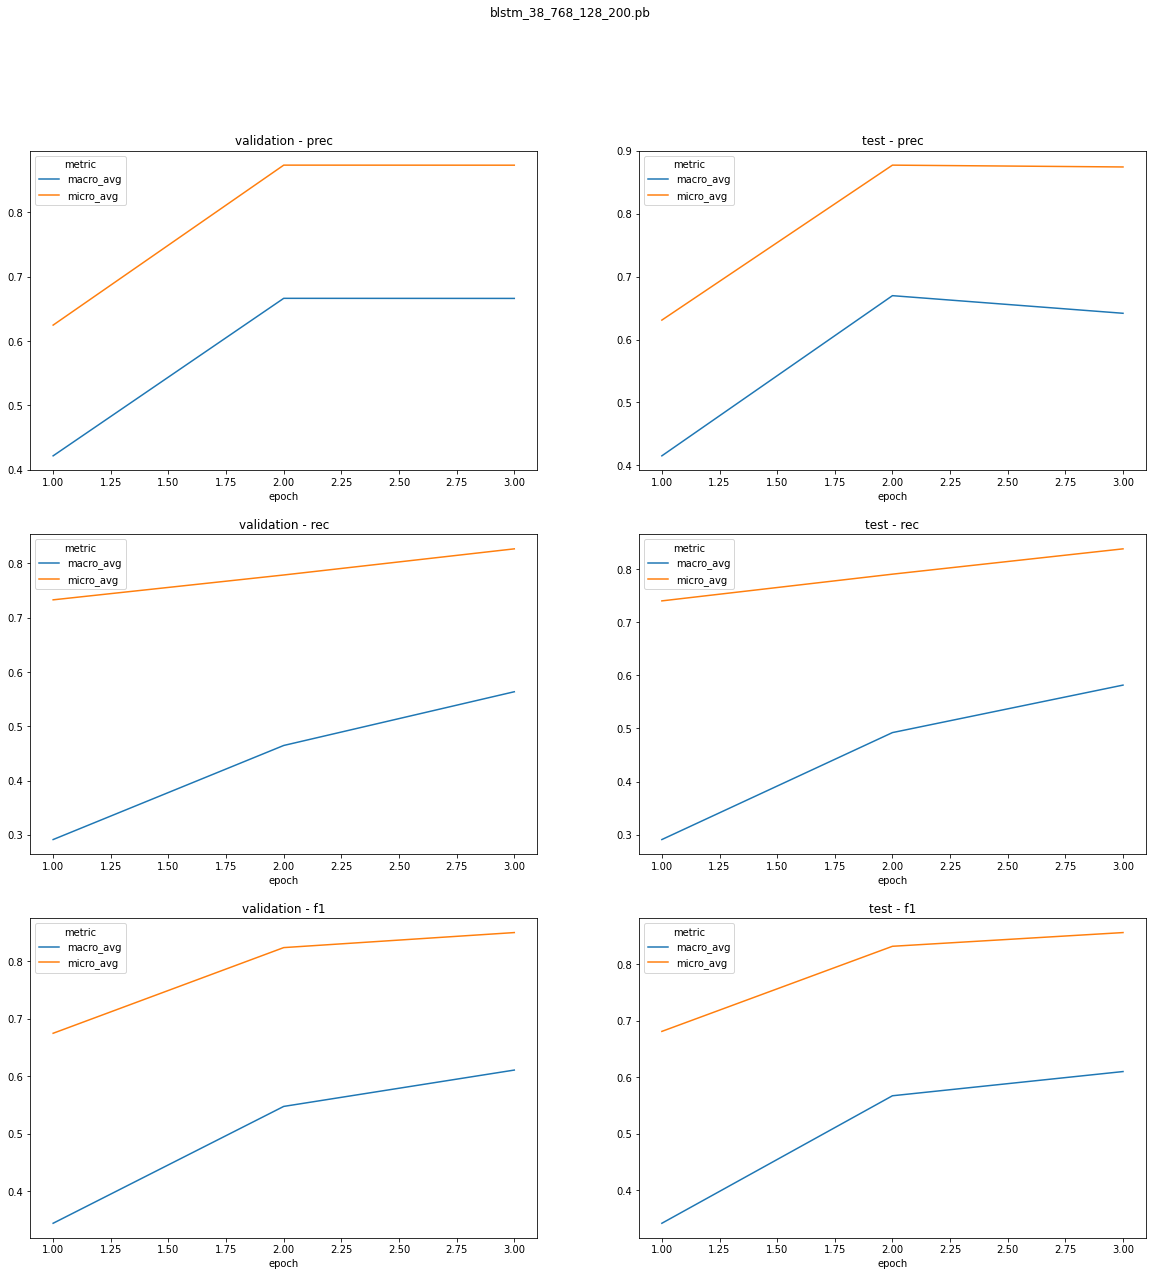

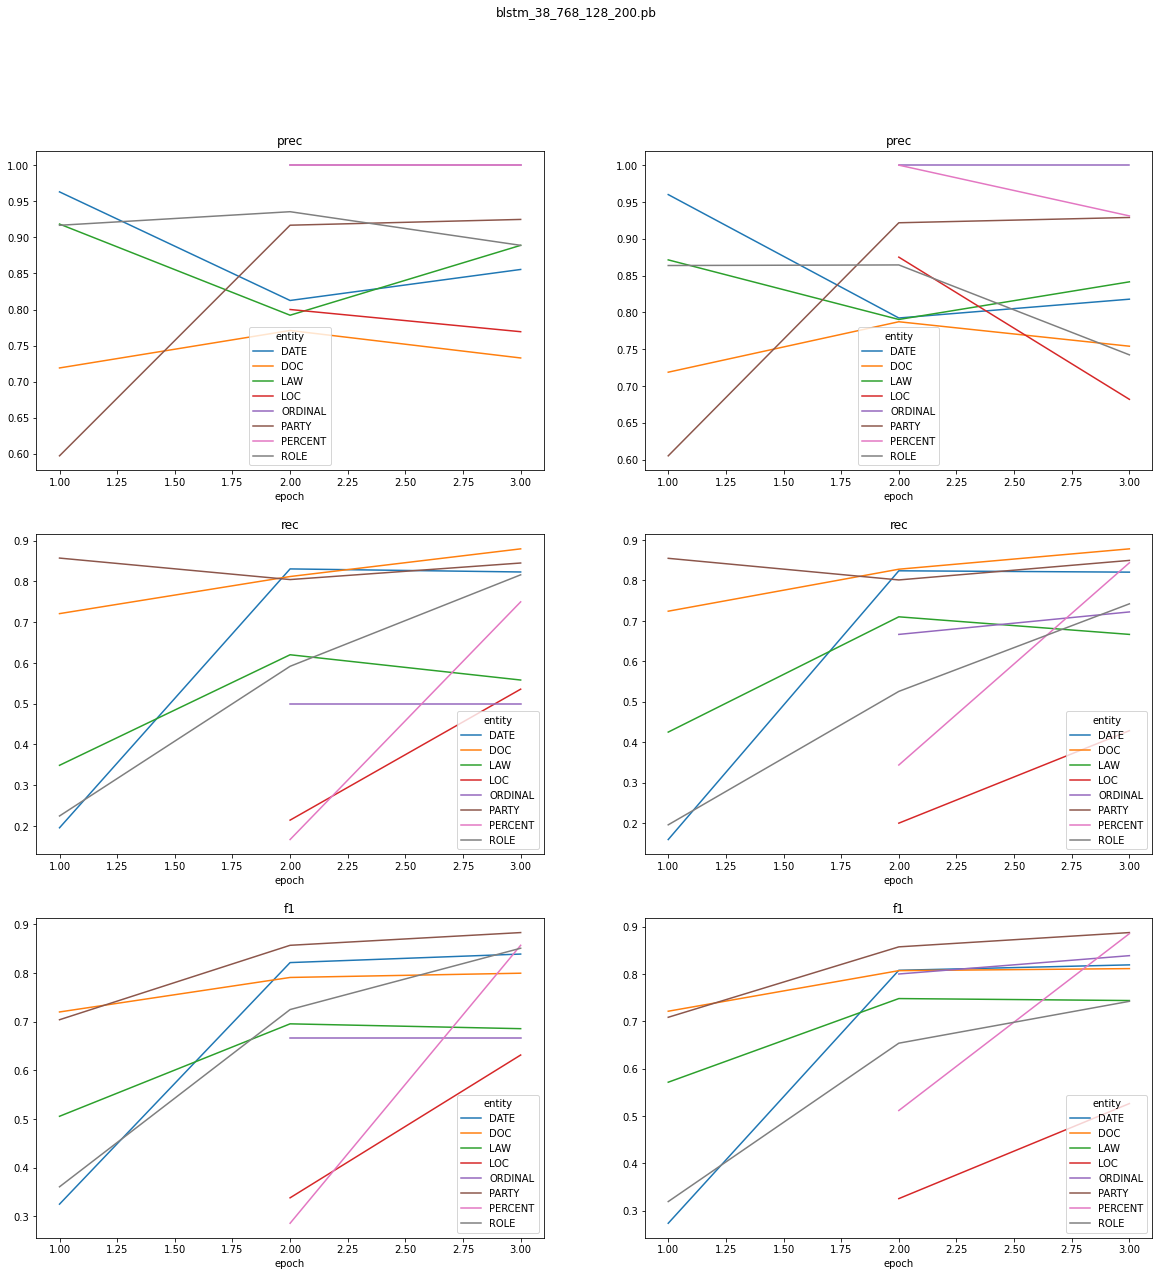

In [0]:
import ner_log_parser
%matplotlib inline

ner_log_parser.get_charts('/dbfs/ner_logs_best/'+log_files[0])

**Plotting Loss**

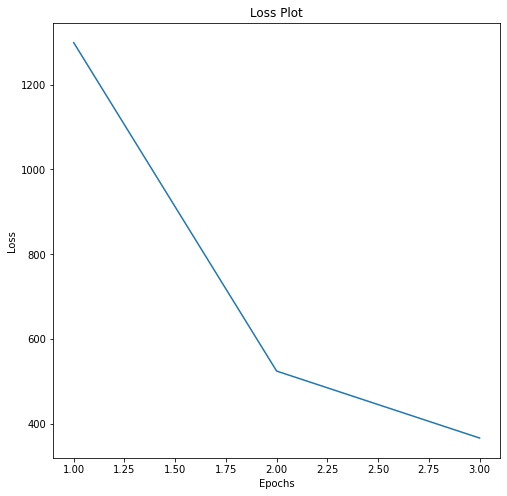

In [0]:
ner_log_parser.loss_plot('/dbfs/ner_logs_best/'+log_files[0])

###📌 Saving the trained model

In [0]:
ner_model.stages

Out[53]: [LegalNerModel_9704f2df3363]

In [0]:
ner_model.stages[-1].write().overwrite().save('dbfs:/databricks/driver/models/NER_bert_e5_b32')

##📌 Prediction Pipeline

In [0]:
document = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

textSplitter = legal.TextSplitter()\
    .setInputCols(['document'])\
    .setOutputCol('sentence')

token = nlp.Tokenizer()\
    .setInputCols(['sentence'])\
    .setOutputCol('token')

roberta_embeddings = nlp.RoBertaEmbeddings.pretrained("roberta_embeddings_legal_roberta_base","en") \
    .setInputCols(["sentence", "token"]) \
    .setOutputCol("embeddings") \
    .setMaxSentenceLength(512)
  
# load trained model
loaded_ner_model = legal.NerModel.load("dbfs:/databricks/driver/models/NER_bert_e5_b32")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner")

converter = nlp.NerConverter()\
    .setInputCols(["document", "token", "ner"])\
    .setOutputCol("ner_span")

ner_prediction_pipeline = nlp.Pipeline(stages = [
                                            document,
                                            textSplitter,
                                            token,
                                            roberta_embeddings,
                                            loaded_ner_model,
                                            converter
                                            ])

roberta_embeddings_legal_roberta_base download started this may take some time.
Approximate size to download 447.2 MB
[ | ][OK!]

In [0]:
empty_data = spark.createDataFrame([['']]).toDF("text")

prediction_model = ner_prediction_pipeline.fit(empty_data)

In [0]:
text = """ARTICLE II ENGAGEMENT OF ZEBRA BRAZIL 6"""

sample_data = spark.createDataFrame([[text]]).toDF("text")

sample_data.show(truncate=False)

+---------------------------------------+
text |
+---------------------------------------+
ARTICLE II ENGAGEMENT OF ZEBRA BRAZIL 6|
+---------------------------------------+

In [0]:
%%time
preds = prediction_model.transform(sample_data)

preds.select(F.explode(F.arrays_zip(preds.ner_span.result,
                                    preds.ner_span.metadata)).alias("entities")) \
      .select(F.expr("entities['0']").alias("chunk"),
              F.expr("entities['1'].entity").alias("entity")).show(truncate=False)

+-----------------------------+------+
chunk |entity|
+-----------------------------+------+
II ENGAGEMENT OF ZEBRA BRAZIL|DOC |
+-----------------------------+------+

CPU times: user 33.1 ms, sys: 14.8 ms, total: 47.9 ms
Wall time: 2.18 s

In [0]:
light_model = nlp.LightPipeline(prediction_model)

In [0]:
%%time
text = """ARTICLE II ENGAGEMENT OF ZEBRA BRAZIL 6"""

result_ann = light_model.annotate(text)

list(zip(result_ann['token'], result_ann['ner']))

CPU times: user 22.2 ms, sys: 6.87 ms, total: 29.1 ms
Wall time: 686 ms
Out[60]: [('ARTICLE', 'O'),
 ('II', 'B-DOC'),
 ('ENGAGEMENT', 'I-DOC'),
 ('OF', 'I-DOC'),
 ('ZEBRA', 'I-DOC'),
 ('BRAZIL', 'I-DOC'),
 ('6', 'O')]

In [0]:
%%time
import pandas as pd

result = light_model.fullAnnotate(text)

ner_df= pd.DataFrame([(int(x.metadata['sentence']), x.result, x.begin, x.end, y.result) for x,y in zip(result[0]["token"], result[0]["ner"])], 
                      columns=['sent_id','token','start','end','ner'])
ner_df

CPU times: user 21.3 ms, sys: 8.96 ms, total: 30.3 ms
Wall time: 263 ms
Out[62]:

,sent_id,token,start,end,ner
0,0,ARTICLE,0,6,O
1,0,II,8,9,B-DOC
2,0,ENGAGEMENT,11,20,I-DOC
3,0,OF,22,23,I-DOC
4,0,ZEBRA,25,29,I-DOC
5,0,BRAZIL,31,36,I-DOC
6,0,6,38,38,O


###📚 Highlight Entities

In [0]:
from sparknlp_display import NerVisualizer

result = result[0]
visualiser = nlp.viz.NerVisualizer()
displayHTML(visualiser.display(result, label_col='ner_span', document_col='document', return_html = True))

ARTICLE II ENGAGEMENT OF ZEBRA BRAZIL DOC 6